In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from catboost import *
%matplotlib inline

In [3]:
data = pd.read_csv('train.csv')
data.head()

id  X0      X1    X2      X3    X4  X5  X6  X7  X8  ...  X13  X14  X15  \
0   0   2  908749   954  480270   935  71  79  53  89  ...   51  100   87   
1   1   1  438444  2162  486685  2154  32  39  48  49  ...   39   83   91   
2   2   1  596915  2066  711059  2081  43  21  58  94  ...    7   52   37   
3   3   1  625198  1508   66810  1474   7   1  34  73  ...   39   27   55   
4   4   2  228654  1202  542816  1196  53  35  16  80  ...   35   95   50   

   X16  X17  X18  X19  X20  X21  target  
0    3   61   48   43   79  329       0  
1    6   57   94   15   89  581       1  
2   50   69   60   89   10  548       0  
3   97   83    1   88   87  555       1  
4   55   10   49   12   68  651       0  

[5 rows x 24 columns]

Разделим выборку на обучение и валидацию, в попытках избежать переобучение. Пропусков или Nan в данных нету (проверенно в черновиках) поэтому работаем с таблицей как есть.

In [4]:
y = data.target
X = data.drop(['target', 'id'], axis=1)

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

## В Лоб

Попробуем решить задачу в лоб, с помощью логистической регрессии. Будем брать данные как они есть и работать с ними как с числовыми. Предварительно только отнормируем их.

In [13]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=241)

Константу регуляризации подберем перебором.

In [9]:
def scorer_logreg(X, y):
    scores = {}

    for i in range(-3, 3):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=241)

        score = cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        
        scores[i] = score
        print()

    return pd.Series(scores)

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664



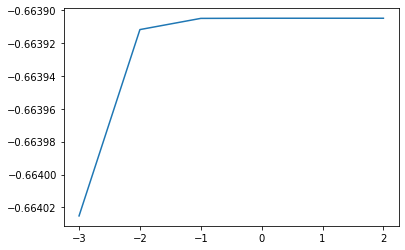

In [10]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

Как видно, константа регуляризации повлияла незначительно на качество решения.

## Data Engineering

Попробуем поработать с признаками. Нагенерировать новых и определить какие признаки наиболее значимы. Можно было бы попробовать применить различные кодирования, например, one-Hot или Lable Encoding или просто захешировать их, то это значительно увеличит датасет, а как показывает практика к улучшению результат не приведет (пробовал)

In [6]:
def hash_(x):
    hash_space = 50
    return list(map(lambda y: hash(y) % hash_space, x))

Предположим, что id юнитов как-то связаны с численностью юнита и будем работать с этим признаком как с числовым для генерации новых фичей.

In [7]:
def data_prepairing(X):
    army_count_1 = X['X5'] + X['X7'] + X['X9'] + X['X11'] + X['X13'] + X['X15'] + X['X17'] + X['X19'] # размер войска первого игрока
    army_count_2 = X['X6'] + X['X8'] + X['X10'] + X['X12'] + X['X14'] + X['X16'] + X['X18'] + X['X20'] # размер войска второго игрока
    
    X['army_relation'] = list(map(lambda x: 1 if x > 1 else 0, army_count_1/army_count_2)) # отношение размеров армиий
    X['army_diff'] = hash_(army_count_1 - army_count_2) # разница численности войск
    X['army_1'] = army_count_1
    X['army_2'] = army_count_2
    X['rank1_time'] = hash_(X['X2'] * X['X21']) # рейтинг игрока 1 и время игры
    X['rank2_time'] = hash_(X['X4'] * X['X21']) # рейтинг игрока 1 и время игры
    X['type_time'] = hash_(X['X0'] * X['X21']) # тип игрока 1 и время игры
    X['pers1_time'] = hash_(X['X1'] * X['X21']) # id игрока 1 и время игры
    X['pers2_time'] = hash_(X['X3'] * X['X21']) # id игрока 1 и время игры
    X['rank_relation'] = list(map(lambda x: 1 if x > 1 else 0, X['X2']/(X['X4']))) # отношение рейтингков игроков
    X['rank_diff'] = hash_(X['X2'] - X['X4']) # разность рейтингов игроков
    
    return X

In [8]:
X = data_prepairing(X)

In [9]:
X.head()

X0      X1    X2      X3    X4  X5  X6  X7  X8   X9  ...  army_diff  \
0   2  908749   954  480270   935  71  79  53  89   15  ...         27   
1   1  438444  2162  486685  2154  32  39  48  49  100  ...         35   
2   1  596915  2066  711059  2081  43  21  58  94   88  ...         16   
3   1  625198  1508   66810  1474   7   1  34  73    6  ...         19   
4   2  228654  1202  542816  1196  53  35  16  80   72  ...         36   

   army_1  army_2  rank1_time  rank2_time  type_time  pers1_time  pers2_time  \
0     456     479          16          15          8          21          30   
1     439     404          22          24         31          14          35   
2     407     441          18          38         48          20          32   
3     332     413          40          20          5          40           0   
4     291     505           2          46          2           4          16   

   rank_relation  rank_diff  
0              1         19  
1              1          8  
2              0         35  
3              1         34  
4              1          6  

[5 rows x 33 columns]

In [10]:
X.keys()

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'army_relation', 'army_diff', 'army_1', 'army_2', 'rank1_time',
       'rank2_time', 'type_time', 'pers1_time', 'pers2_time', 'rank_relation',
       'rank_diff'],
      dtype='object')

Нагенерировали кучу признаков, теперь посмотрим какие из них действительно важные. Для этого воспользуемся подходом Recursive feature elimination with cross-validation а в качестве классификатора возьмем случайный лес

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=5)

trans = RFECV(clf, scoring=log_loss)
X_trans = trans.fit_transform(X, y)

In [48]:
X.loc[:, trans.get_support()].head()

X2  X6  X11  X19  rank_relation  rank_diff
0   954  79   75   43              1         19
1  2162  39   57   15              1          8
2  2066  21   16   89              0         35
3  1508   1   20   88              1         34
4  1202  35   43   12              1          6

Судя по RFECV, наиболее значимые признаки для модели: 'X2', 'X6', 'X11', 'X19', 'rank_relation', 'rank_diff'

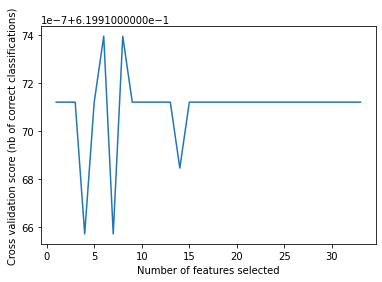

In [36]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(trans.grid_scores_) + 1),
         trans.grid_scores_)
plt.show()

In [11]:
selected_features = ['X2', 'X6', 'X11', 'X19', 'rank_relation', 'rank_diff']

In [15]:
X_selected = X.loc[:, selected_features]

X_train, X_validation, y_train, y_validation = train_test_split(X_selected, y, train_size=0.8, random_state=42, shuffle=True)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

C=1e-05
Score: -0.664

C=0.0001
Score: -0.664

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664

C=1000.0
Score: -0.664

C=10000.0
Score: -0.664

C=100000.0
Score: -0.664



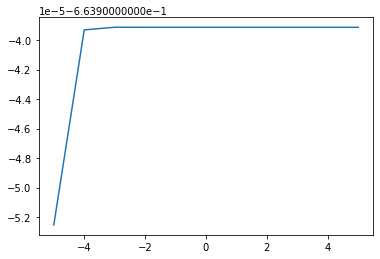

In [73]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

как видно картина изменилась не сильно, хотя теперь наша выборка стала меньше и обучаться модель может быстрее. Попробуем добавить к признакам еще тип игры 'X0', но применим к нему one hot encoding 

In [80]:
X_0 = pd.get_dummies(X['X0'], prefix='X0')

X_selected = pd.concat([X_selected, X_0], axis=1)
X_selected.head()

X2  X6  X11  X19  rank_relation  rank_diff  X0_1  X0_2  X0_3  X0_4  X0_5  \
0   954  79   75   43              1         19     0     1     0     0     0   
1  2162  39   57   15              1          8     1     0     0     0     0   
2  2066  21   16   89              0         35     1     0     0     0     0   
3  1508   1   20   88              1         34     1     0     0     0     0   
4  1202  35   43   12              1          6     0     1     0     0     0   

   X0_6  X0_8  
0     0     0  
1     0     0  
2     0     0  
3     0     0  
4     0     0

In [81]:
X_train, X_validation, y_train, y_validation = train_test_split(X_selected, y, train_size=0.8, random_state=42, shuffle=True)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

C=1e-05
Score: -0.664

C=0.0001
Score: -0.664

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664

C=1000.0
Score: -0.664

C=10000.0
Score: -0.664

C=100000.0
Score: -0.664



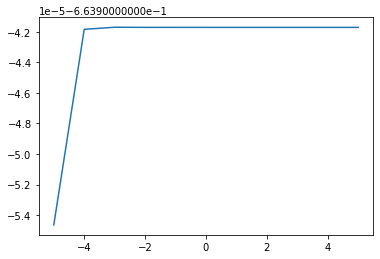

In [82]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

Кажется и это погоды не сделало. Попробуем перейти к более сложной модели.

# CatBoost

In [85]:
X_train, X_validation, y_train, y_validation = train_test_split(X_selected.loc[:, 'X2':'rank_diff'], y, train_size=0.8,
                                                                random_state=42, shuffle=True)

In [86]:
cat_features = list(range(0, X_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [87]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    verbose=10,
    random_seed=42,
    learning_rate=0.7,
    # save_snapshot=True,
    # snapshot_file='snapshot.bkp',
    # snapshot_interval=1,
    # l2_leaf_reg=2.0,
    early_stopping_rounds=20,
    # one_hot_max_size=2,
    # bootstrap_type='Bernoulli',
    # subsample=0.5,
    # random_strength=2,
    use_best_model=True,
    best_model_min_trees=30,
    # rsm=0.5,
    # leaf_estimation_iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    plot=False
)

0:	learn: 0.6665691	test: 0.6662606	best: 0.6662606 (0)	total: 704ms	remaining: 11m 43s
10:	learn: 0.6632284	test: 0.6626057	best: 0.6626057 (10)	total: 14.3s	remaining: 21m 28s
20:	learn: 0.6631602	test: 0.6625761	best: 0.6625760 (19)	total: 24.3s	remaining: 18m 53s
30:	learn: 0.6630750	test: 0.6625662	best: 0.6625659 (29)	total: 32.8s	remaining: 17m 6s
40:	learn: 0.6629851	test: 0.6625541	best: 0.6625521 (39)	total: 40.9s	remaining: 15m 57s
50:	learn: 0.6628956	test: 0.6625552	best: 0.6625521 (39)	total: 49.6s	remaining: 15m 22s
60:	learn: 0.6628122	test: 0.6625479	best: 0.6625374 (55)	total: 57.2s	remaining: 14m 40s
70:	learn: 0.6627213	test: 0.6625520	best: 0.6625374 (55)	total: 1m 5s	remaining: 14m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6625374465
bestIteration = 55

Shrink model to first 56 iterations.


Качество стало лучше, попробуем настроить параметры модели.

Feature Importance для нашей модели.

In [89]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0            X19    23.078232
1             X6    20.163040
2            X11    20.057430
3  rank_relation    15.923471
4             X2    12.880414
5      rank_diff     7.897412

# Hyperparameter tunning

In [94]:
from sklearn.model_selection import GridSearchCV

In [103]:
param_grid = {'l2_leaf_reg': [1, 3, 5],
              'rsm': [0.1, 0.5, 0.7],
             'learning_rate': [0.3, 0.8, 1.5]}
base_estimator = CatBoostClassifier(
    verbose=False,
    n_estimators = 150,
    random_seed=42,
    early_stopping_rounds=20,
    bootstrap_type='Bernoulli',
    best_model_min_trees=30,
    cat_features=cat_features
    )

clf = GridSearchCV(base_estimator, param_grid)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

## Попробуем запустить нейронку, почему бы и нет (Не успел посчитать, листайте дальше)

In [2]:
import torch

In [34]:
X_nn = pd.DataFrame(scaler.fit_transform(X_selected), index=X_selected.index, columns=X_selected.columns)
X_train, X_validation, y_train, y_validation = train_test_split(X_nn, y, train_size=0.6, random_state=42, shuffle=True)

X_nn = torch.Tensor(X_nn.values)
y_nn = torch.Tensor(y.values)

In [35]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X_nn,y_nn)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

C:\Users\kanygin.yy\AppData\Local\Temp/ipykernel_1300/1945983832.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
C:\Users\kanygin.yy\AppData\Local\Temp/ipykernel_1300/1945983832.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)


In [36]:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,6)
        self.fc2 = nn.Linear(6,12)
        self.fc3 = nn.Linear(12,1)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [37]:
#hyper parameters
learning_rate = 0.1
epochs = 300
# Model , Optimizer, Loss
model = Net(input_shape=X_nn.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [38]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = model(torch.tensor(X_nn,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%10 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

C:\Users\kanygin.yy\AppData\Local\Temp/ipykernel_1300/1579491350.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = model(torch.tensor(X_nn,dtype=torch.float32))


epoch 0	loss : 0.6524509787559509	 accuracy : 0.6199171209508382


KeyboardInterrupt: 

In [ ]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

# Best Model

Лучшая модель из того, что успелось посчитаться оказался catboost

In [64]:
data = pd.read_csv('train.csv')
data.head()

id  X0      X1    X2      X3    X4  X5  X6  X7  X8  ...  X13  X14  X15  \
0   0   2  908749   954  480270   935  71  79  53  89  ...   51  100   87   
1   1   1  438444  2162  486685  2154  32  39  48  49  ...   39   83   91   
2   2   1  596915  2066  711059  2081  43  21  58  94  ...    7   52   37   
3   3   1  625198  1508   66810  1474   7   1  34  73  ...   39   27   55   
4   4   2  228654  1202  542816  1196  53  35  16  80  ...   35   95   50   

   X16  X17  X18  X19  X20  X21  target  
0    3   61   48   43   79  329       0  
1    6   57   94   15   89  581       1  
2   50   69   60   89   10  548       0  
3   97   83    1   88   87  555       1  
4   55   10   49   12   68  651       0  

[5 rows x 24 columns]

In [65]:
y = data.target
X = data.drop(['target', 'id'], axis=1)

In [66]:
def data_prepairing2(X):
    army_count_1 = X['X5'] + X['X7'] + X['X9'] + X['X11'] + X['X13'] + X['X15'] + X['X17'] + X['X19']
    army_count_2 = X['X6'] + X['X8'] + X['X10'] + X['X12'] + X['X14'] + X['X16'] + X['X18'] + X['X20']
    X['army_relation'] = list(map(lambda x: 1 if x > 1 else 0, army_count_1/army_count_2))

    X['army_1'] = army_count_1
    X['army_2'] = army_count_2
    X['type_time'] = X['X0'] * X['X21']
    X['pers1_time'] = X['X1'] * X['X21']
    X['pers2_time'] = X['X3'] * X['X21']
    X['rank_relation'] = list(map(lambda x: 1 if x > 1 else 0, X['X2']/(X['X4'])))
    
    return X

In [67]:
X = data_prepairing2(X)

In [68]:
X.head()

X0      X1    X2      X3    X4  X5  X6  X7  X8   X9  ...  X19  X20  X21  \
0   2  908749   954  480270   935  71  79  53  89   15  ...   43   79  329   
1   1  438444  2162  486685  2154  32  39  48  49  100  ...   15   89  581   
2   1  596915  2066  711059  2081  43  21  58  94   88  ...   89   10  548   
3   1  625198  1508   66810  1474   7   1  34  73    6  ...   88   87  555   
4   2  228654  1202  542816  1196  53  35  16  80   72  ...   12   68  651   

   army_relation  army_1  army_2  type_time  pers1_time  pers2_time  \
0              0     456     479        658   298978421   158008830   
1              1     439     404        581   254735964   282763985   
2              0     407     441        548   327109420   389660332   
3              0     332     413        555   346984890    37079550   
4              0     291     505       1302   148853754   353373216   

   rank_relation  
0              1  
1              1  
2              0  
3              1  
4              1  

[5 rows x 29 columns]

In [69]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [70]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

In [71]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    verbose=10,
    random_seed=42,
    learning_rate=0.5,
    # save_snapshot=True,
    # snapshot_file='snapshot.bkp',
    # snapshot_interval=1,
    l2_leaf_reg=5.0,
    early_stopping_rounds=20,
    one_hot_max_size=2,
    bootstrap_type='Bernoulli',
    subsample=0.5,
    random_strength=2,
    use_best_model=True,
    best_model_min_trees=30,
    rsm=0.5,
    leaf_estimation_iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    plot=False
)

0:	learn: 0.6712483	test: 0.6711430	best: 0.6711430 (0)	total: 35.3s	remaining: 9h 47m 50s
10:	learn: 0.6581906	test: 0.6551470	best: 0.6550003 (8)	total: 2m 50s	remaining: 4h 15m 27s
20:	learn: 0.6562710	test: 0.6527048	best: 0.6527048 (20)	total: 5m 15s	remaining: 4h 5m 15s
30:	learn: 0.6551632	test: 0.6512121	best: 0.6512121 (30)	total: 7m 25s	remaining: 3h 51m 56s
40:	learn: 0.6544248	test: 0.6503379	best: 0.6503379 (40)	total: 11m 40s	remaining: 4h 33m 7s
50:	learn: 0.6539704	test: 0.6498394	best: 0.6498394 (50)	total: 14m 46s	remaining: 4h 34m 55s
60:	learn: 0.6534596	test: 0.6494748	best: 0.6494748 (60)	total: 17m 19s	remaining: 4h 26m 41s
70:	learn: 0.6532697	test: 0.6493506	best: 0.6493506 (70)	total: 19m 24s	remaining: 4h 13m 57s
80:	learn: 0.6530795	test: 0.6492161	best: 0.6492161 (80)	total: 22m 25s	remaining: 4h 14m 28s
90:	learn: 0.6528992	test: 0.6491185	best: 0.6491185 (90)	total: 24m 46s	remaining: 4h 7m 31s
100:	learn: 0.6527674	test: 0.6490569	best: 0.6490569 (100)	t

# Calculate predictions for the contest

In [72]:
data_test = pd.read_csv('test.csv')
data_test.head()

id  X0       X1    X2       X3    X4  X5   X6  X7  X8  ...  X12  X13  X14  \
0   0   1  1032217  1187  1011523  1172  57  100   1  80  ...   79   45   18   
1   1   2  1059033  2128   505263  2104  82   27  87  79  ...   74   96   55   
2   2   1   207787  1017   822639  1040  82   48  43  62  ...   16   64   35   
3   3   1  1095582  1449    32841  1424  71   43  11  98  ...    1    7   41   
4   4   2   963764  1202   489871  1182  11   62  16  55  ...   26   60   37   

   X15  X16  X17  X18  X19  X20  X21  
0   35   10   80   81   16    0  547  
1   54   48    3   92    5   51  656  
2   70   99   60   30   37   45  437  
3   94   26   52   45   81    1  589  
4    7    1   80   48   50   52  340  

[5 rows x 23 columns]

In [73]:
X_test = data_test.drop(['id'], axis=1)
X_test.head()

X0       X1    X2       X3    X4  X5   X6  X7  X8  X9  ...  X12  X13  X14  \
0   1  1032217  1187  1011523  1172  57  100   1  80  25  ...   79   45   18   
1   2  1059033  2128   505263  2104  82   27  87  79  80  ...   74   96   55   
2   1   207787  1017   822639  1040  82   48  43  62  18  ...   16   64   35   
3   1  1095582  1449    32841  1424  71   43  11  98  80  ...    1    7   41   
4   2   963764  1202   489871  1182  11   62  16  55  88  ...   26   60   37   

   X15  X16  X17  X18  X19  X20  X21  
0   35   10   80   81   16    0  547  
1   54   48    3   92    5   51  656  
2   70   99   60   30   37   45  437  
3   94   26   52   45   81    1  589  
4    7    1   80   48   50   52  340  

[5 rows x 22 columns]

In [74]:
X_test = data_prepairing2(X_test)

In [75]:
X_test.head()

X0       X1    X2       X3    X4  X5   X6  X7  X8  X9  ...  X19  X20  X21  \
0   1  1032217  1187  1011523  1172  57  100   1  80  25  ...   16    0  547   
1   2  1059033  2128   505263  2104  82   27  87  79  80  ...    5   51  656   
2   1   207787  1017   822639  1040  82   48  43  62  18  ...   37   45  437   
3   1  1095582  1449    32841  1424  71   43  11  98  80  ...   81    1  589   
4   2   963764  1202   489871  1182  11   62  16  55  88  ...   50   52  340   

   army_relation  army_1  army_2  type_time  pers1_time  pers2_time  \
0              0     302     455        547   564622699   553303081   
1              0     495     497       1312   694725648   331452528   
2              1     457     395        437    90802919   359493243   
3              1     431     288        589   645297798    19343349   
4              1     388     373        680   327679760   166556140   

   rank_relation  
0              1  
1              1  
2              0  
3              1  
4              1  

[5 rows x 29 columns]

In [76]:
y_test = model.predict_proba(X_test)
y_test = y_test[:, 1]

# Prepare the submission

In [77]:
ans = pd.DataFrame(data=y_test, columns=["target"])
ans.reset_index(level=0, inplace=True)
ans.reset_index(drop=True, inplace=True)
ans = ans.rename(columns={'index':'id'})
ans.head()

id    target
0   0  0.385225
1   1  0.350039
2   2  0.305285
3   3  0.358886
4   4  0.339945

In [81]:
ans.to_csv('submission.csv',index=False)